In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib
from matplotlib.ticker import MaxNLocator
set1 = sns.color_palette('Set1')
sns.set_palette('Set1')

import requests
from bs4 import BeautifulSoup

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
url = "https://www.worldometers.info/coronavirus/"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')


t = soup.find(id="main_table_countries_today").text

a = np.array(t.strip().split("\n"))

b = a[153:]

columns = ['Country', 'TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', '', '', 'Continent']
df = pd.DataFrame(np.split(b, range(15, len(b), 15)), columns=columns).iloc[:212]

def convert_float(field):
    field = field.replace(',', '')
    try:
        return float(field)
    except ValueError:
        return None

for c in ['TotCases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']:
    df[c] = df[c].apply(convert_float)

for c in ['TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotalTests']:
    df[c] = df[c].apply(convert_float)
df.sort_values('TotalCases', ascending=False).head(20)

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotCases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,,,Continent
0,USA,710272.0,537.0,37175.0,21.0,63510.0,609587.0,13509.0,2146.0,112.0,3579797.0,10815.0,North America,,
1,Spain,190839.0,NaN,20002.0,NaN,74797.0,96040.0,7371.0,4082.0,428.0,930230.0,19896.0,Europe,,
2,Italy,172434.0,NaN,22745.0,NaN,42727.0,106962.0,2812.0,2852.0,376.0,1244108.0,20577.0,Europe,,
3,France,147969.0,NaN,18681.0,NaN,34420.0,94868.0,6027.0,2267.0,286.0,463662.0,7103.0,Europe,,
4,Germany,141397.0,NaN,4352.0,NaN,83114.0,53931.0,5013.0,1688.0,52.0,1728357.0,20629.0,Europe,,
5,UK,108692.0,NaN,14576.0,NaN,NaN,93772.0,1559.0,1601.0,215.0,438991.0,6467.0,Europe,,
211,China,82719.0,27.0,4632.0,NaN,77029.0,1058.0,85.0,57.0,3.0,NaN,NaN,Asia,,
6,Iran,79494.0,NaN,4958.0,NaN,54064.0,20472.0,3563.0,946.0,59.0,319879.0,3808.0,Asia,,
7,Turkey,78546.0,NaN,1769.0,NaN,8631.0,68146.0,1845.0,931.0,21.0,558413.0,6621.0,Asia,,
8,Belgium,36138.0,NaN,5163.0,NaN,7961.0,23014.0,1140.0,3118.0,445.0,139387.0,12027.0,Europe,,


In [3]:
hun_list = []
page_i = 0
while True:
    try:
        t = pd.read_html(f"https://koronavirus.gov.hu/elhunytak/?page={page_i}")[0]
        page_i += 1
        hun_list.append(t)
    except ValueError:
        break
hun = pd.concat(hun_list)
hun = hun.rename(columns={
   'Sorszám': 'id',
    'Nem': 'gender',
    'Kor': 'age',
    'Alapbetegségek': 'conditions'
})
hun = hun.drop('id', axis=1)

# Általános statisztikák

In [4]:
print("Összes elhunyt:", len(hun))
print("Átlagéletkor:", hun.age.mean().round(1))
print("Medián életkor:", hun.age.median())
print("Életkor szórása:", hun.age.std().round(1))
gc = hun.gender.value_counts()
print("Férfi: {}, Nő: {}".format(gc.loc['Férfi'], gc.loc['Nő']))

Összes elhunyt: 172
Átlagéletkor: 77.4
Medián életkor: 78.5
Életkor szórása: 11.5
Férfi: 95, Nő: 77


In [5]:
daily_stats = pd.read_table("daily_stats.tsv", index_col="day", parse_dates=['day'])
today = pd.Timestamp.today()
if today.date() not in daily_stats.index:
    print("Adding today's stats")
    daily_stats.loc[today, "cnt"] = len(hun)
    daily_stats.loc[today, 'M'] = gc.loc['Férfi']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'M']
    daily_stats.loc[today, 'F'] = gc.loc['Nő']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'F']
    daily_stats.index = daily_stats.index.map(lambda i: i.date())
    
    headers = requests.utils.default_headers()
    headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
    url = "https://koronavirus.gov.hu/"
    req = requests.get(url, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    for d in soup.find_all("div", class_="diagram-a"):
        label = d.find("span", class_="label").get_text()
        number = d.find("span", class_="number")
        if number:
            number = number.get_text().replace(" ", "")
            daily_stats.loc[today.date(), label] = int(number)
    daily_stats.to_csv("daily_stats.tsv", sep="\t")
daily_stats = daily_stats.rename(columns={'Fertőzött': 'case', 'Gyógyult': 'recovered'})

Adding today's stats


In [6]:
lineplot_kws = dict(marker='X', linewidth=3, markersize=10)

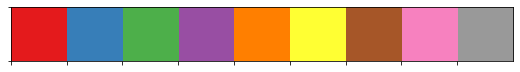

In [7]:
sns.palplot(sns.color_palette('Set1'))

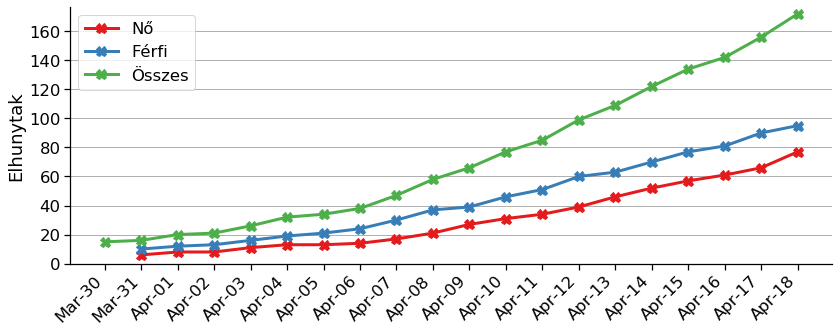

In [8]:
d = daily_stats.copy()
d = d.rename(columns={'M': 'Férfi', 'F': 'Nő', 'cnt': 'Összes'})
m = sns.color_palette('Set1')
cmap = [m[0], m[1], m[2]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Nő', 'Férfi', 'Összes'], color=cmap, ax=ax, **lineplot_kws)
    ax.set_ylim(0, len(hun)+5)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Elhunytak")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_death_count.png", dpi=200)

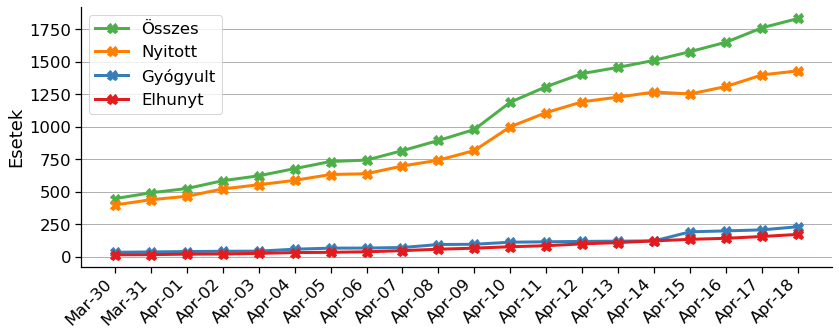

In [9]:
d = daily_stats.copy()
d = d.rename(columns={'recovered': 'Gyógyult', 'case': 'Összes', 'cnt': 'Elhunyt'})
d['Nyitott'] = d['Összes'] - d['Gyógyult'] - d['Elhunyt']
m = sns.color_palette('Set1')
cmap = [m[2], m[4], m[1], m[0]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Összes', 'Nyitott', 'Gyógyult', 'Elhunyt'], color=cmap, ax=ax, **lineplot_kws)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Esetek")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_all.png", dpi=200)

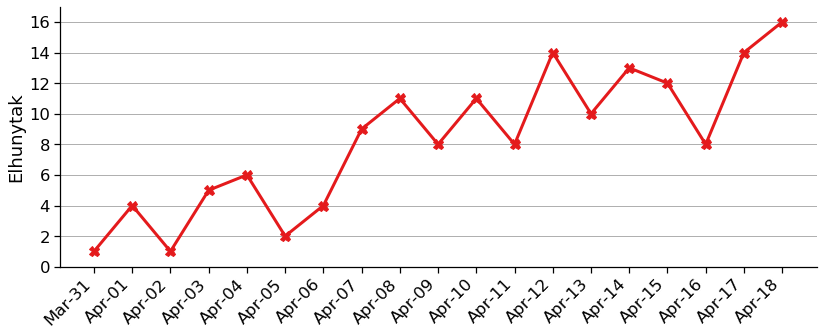

In [10]:
d = daily_stats.cnt.diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_new_deaths.png", dpi=200)

# Meggyógyult / elhunyt naponta

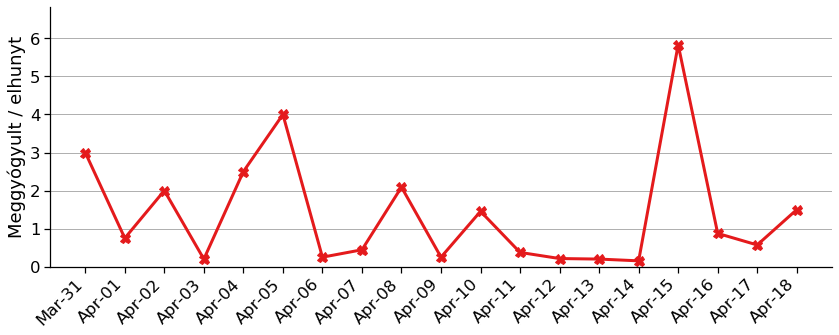

In [11]:
d = daily_stats[['cnt', 'recovered']].diff()
d['recovery/death'] = d['recovered'] / d['cnt']
d = d['recovery/death']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Meggyógyult / elhunyt")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_recovered_per_death.png", dpi=200)

In [12]:
daily_stats

,cnt,M,F,case,recovered,Hatósági házi karanténban,Mintavétel
day,,,,,,,
2020-03-30,15.0,NaN,NaN,447.0,34.0,NaN,NaN
2020-03-31,16.0,10.0,6.0,492.0,37.0,NaN,NaN
2020-04-01,20.0,12.0,8.0,525.0,40.0,NaN,NaN
2020-04-02,21.0,13.0,8.0,585.0,42.0,NaN,NaN
2020-04-03,26.0,16.0,11.0,623.0,43.0,NaN,NaN
2020-04-04,32.0,19.0,13.0,678.0,58.0,NaN,NaN
2020-04-05,34.0,21.0,13.0,733.0,66.0,13435.0,21250.0
2020-04-06,38.0,24.0,14.0,744.0,67.0,14325.0,22282.0
2020-04-07,47.0,30.0,17.0,817.0,71.0,14997.0,23746.0


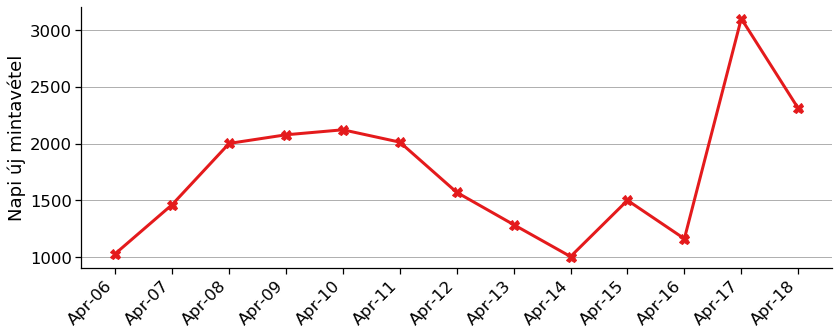

In [13]:
d = daily_stats['Mintavétel'].diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Napi új mintavétel")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_tests_per_day.png", dpi=200)

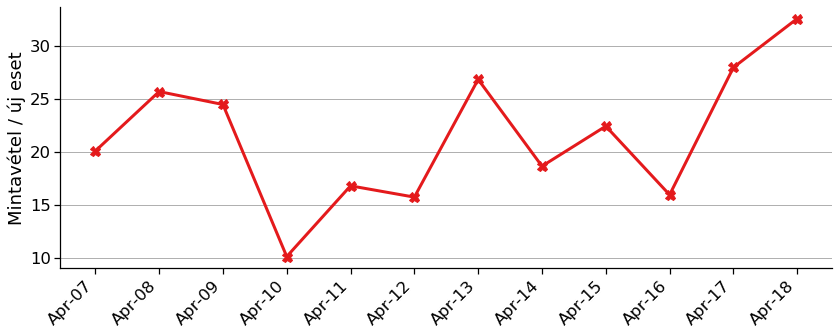

In [14]:
d = daily_stats[['case', 'Mintavétel']].diff()
d['Mintavétel/új eset'] = d['Mintavétel'] / d['case']
d = d['Mintavétel/új eset']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.dropna().iloc[1:].plot(ax=ax, **lineplot_kws)
    #ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Mintavétel / új eset")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_test_per_case.png", dpi=200)

# Korosztályonként

In [15]:
labels = ['40 alatt', '40-49', '50-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-90', '90 felett']
hun['age_group'] = pd.cut(hun.age, bins=[0, 39, 49, 59, 64, 69, 74, 79, 84, 89, 120], labels=labels)

In [16]:
barplot_kws = dict(alpha=0.8, color=sns.color_palette('Set1')[2], zorder=3)

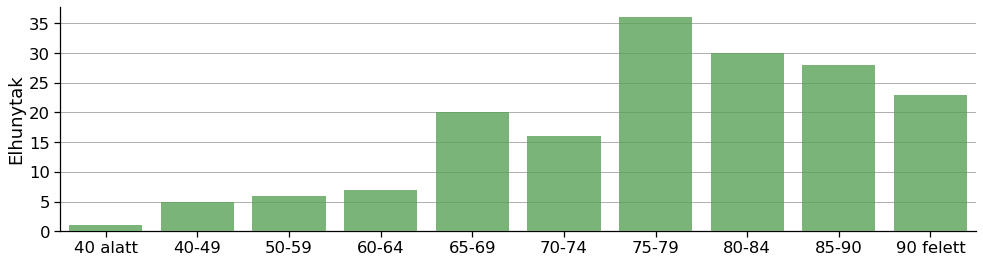

In [17]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(14, 4))
    sns.countplot(hun.age_group, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    ax.grid(axis='y')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group.png", dpi=200)

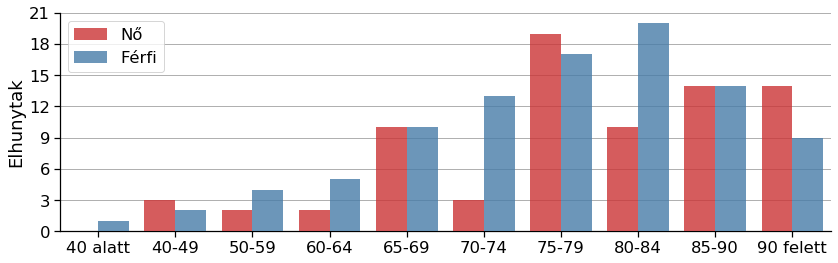

In [18]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 4))
    h = hun.groupby(['gender', 'age_group']).size().reset_index()
    h = h.rename(columns={0: 'cnt'})
    sns.barplot(x=h.age_group, y=h.cnt, hue=h.gender, ax=ax, hue_order=['Nő', 'Férfi'],
                palette=[set1[0], set1[1]], **barplot_kws)
    ax.legend(title="", loc='upper left', fancybox=True)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group_and_gender.png", dpi=200)

# Alapbetegségek

In [19]:
name_mapping = {}
with open("name_mapping.tsv") as f:
    for line in f:
        fd = line.strip().split("\t")
        name_mapping[fd[0]] = fd[1]

list_of_conditions = []
norm_map = {
    "anyagcsere és daganatos betegség": "anyagcsere betegség, daganatos betegség",
    "szív- és veseelégtelenség": "szívelégtelenség, veseelégtelenség",
}

def split_conditions(conditions):
    conditions = conditions.strip()
    cnt = 0
    if conditions in ("adat feltöltés alatt", "adatok feltöltése folyamatban", "adat feltöltése folyamatban", "nincs adat", "adatok feltöltés alatt"):
        return None
    conditions = conditions.replace("\xa0", " ")
    for src, tgt in norm_map.items():
        conditions = conditions.replace(src, tgt)
    for c in conditions.split(","):
        c = c.strip()
        if not c:
            continue
        c = name_mapping.get(c, c)
        list_of_conditions.append(c)
        cnt += 1
    return cnt
        
hun['condition_count'] = hun.conditions.apply(split_conditions)

lc = Counter(list_of_conditions)
conditions = pd.Series(lc)
conditions = conditions.reset_index().rename(columns={'index': 'condition', 0: 'cnt'})

categories = pd.read_table("categories.tsv", names=['condition', 'category'], skiprows=1)
all_cond = set(categories.condition.values)
for c in categories.category.unique():
    if c not in all_cond:
        categories = categories.append(pd.Series({'condition': c, 'category': c}), ignore_index=True)

conditions = conditions.merge(categories, on='condition', how='left')

# Alapbetegségek száma

Hány olyan elhunyt van, akinek 0, 1 vagy több alapbetegsége van.

In [20]:
cond_cnt = hun.condition_count.value_counts(dropna=False).sort_index()
cond_cnt['NA'] = cond_cnt.loc[np.nan]

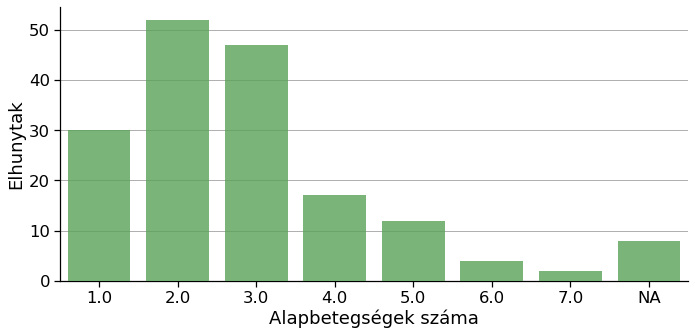

In [21]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    #sns.countplot(hun.condition_count, ax=ax, **barplot_kws)
    sns.barplot(x=cond_cnt.index, y=cond_cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("Alapbetegségek száma")
    sns.despine()
    ax.grid(axis='y', zorder=0)
    plt.tight_layout()
    fig.savefig("fig/condition_histogram.png", dpi=200)

# 10 leggyakoribb betegség

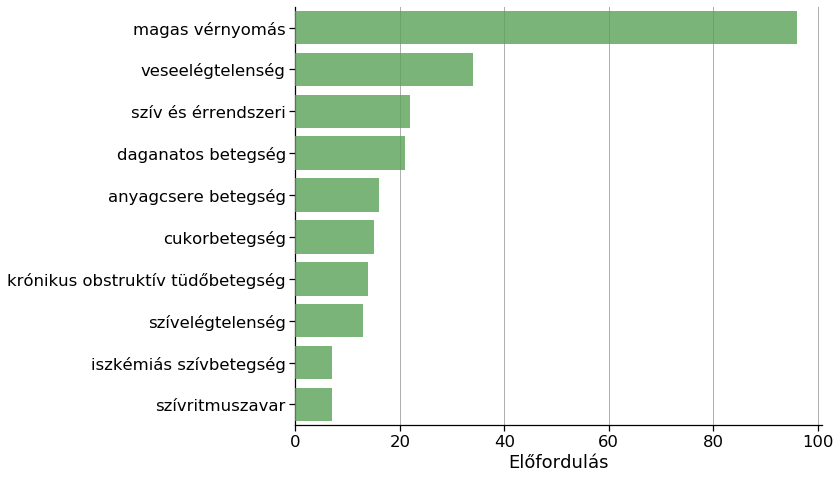

In [22]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.sort_values('cnt', ascending=False).head(10)
    sns.barplot(y=common.condition, x=common.cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.set_xlabel("Előfordulás")
    ax.grid(axis='x')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_most_common_diseases.png", dpi=200)

# Kategóriák

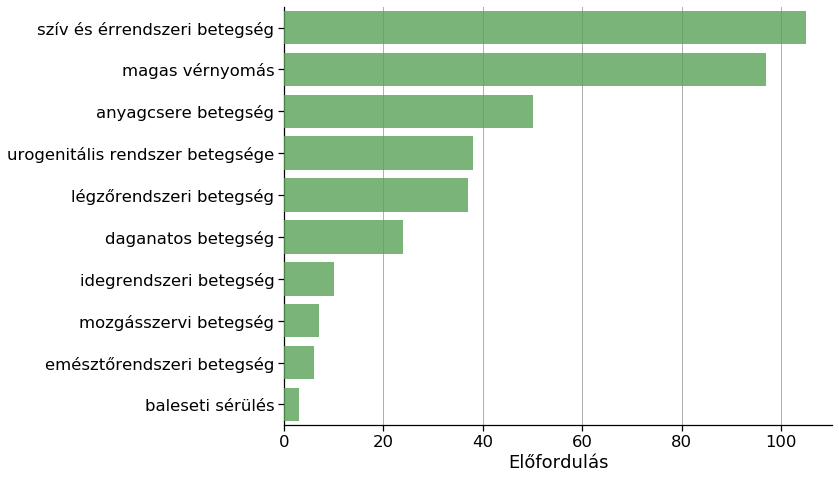

In [23]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.groupby('category')['cnt'].sum().sort_values(ascending=False).head(10)
    sns.barplot(y=common.index, x=common, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.grid(axis='x')
    ax.set_xlabel("Előfordulás")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_icd.png", dpi=200)

In [24]:
print("\n".join(conditions[conditions.category.isnull()].condition))

pneumonia hypostatica l.d. in obs.
Urocystitis
Huntington kór
általános érelmeszesedés
alapbetegség: érelmeszesédés
Motoneuron betegség Kísérõbetegség: ISZB
M. hypertonicus
Mitr. et ao. insuff. valv.
Hyperthyreosis
Fibr. auric. St.p. cholecytectomiam
endokrin betegség
szív és agyi erek meszesedése
művese kezelés
tüdőembolia
atrophia cer.
LC cholecystect.
cataracta műtét
portalis encephalopathia
csontvelői kóros vérképzés tünetegyüttes
pajzsmirigy elégtelenség
verőérbetegség
végstádiumú vesebetegség
generalizált agyi
szív-és érrendszeri érelmeszesedés
vastagbélrák
Parkinsor-kór
agyérelmeszesedés
koszorúér-betegség
agyérelmeszedés
hólyagtumor
idült szívizom elégtelenség
tüdőtágulat
stroke következményei
májzsugor
májeredetű agyvelő bántalom
epeműtét utáni állapot
szövődményes diabetes mellitus (cukorbetegség)
maior amputáció
agyi keringési zavar
encephalopathia (agykárosodás)
Parkinson-kór
PEG táplálás
cachexia
Alzheimer-kór
organikus hangulatzavar
inkontinencia
vesetranszplantált
